# TP2: From coordinate descent to second order methods

#### Authors: O. Fercoq, S. Gaiffas, A. Gramfort

The aim of this material is to go beyond gradient methods to tackle regression and classification optimization problems.

This will cover:

- Part 1 : Coordinate descent for the Lasso problem
- Part 2 : Newton method with and without Armijo line-search on Logistic regression
- Part 3 : L-BFGS on Logistic regression

This work should be done by pairs of students. One document for each pair of students should be sent to:

alexandre.gramfort@telecom-paristech.fr

**PLEASE use as object/title for your email "TP2-DS-Optim"**

In [1]:
# to embed figures in the notebook
%matplotlib inline

## Part 1 : Coordinate descent for the lasso

We'll start by generating sparse vectors and simulating data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

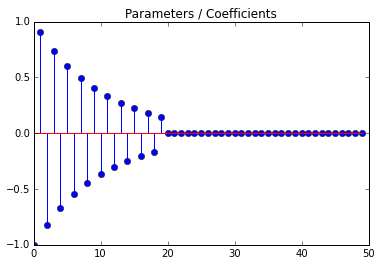

In [3]:
n_features = 50
n_samples = 2000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

In [4]:
# Simulation of the features matrix
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz

# Correlation
rho = 0.7

# Construction of a covariance matrix
cov = toeplitz(rho ** np.arange(0, n_features))

# Simulation of Gaussian vectors with this covariance matrix (it will be the features)
A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)

from numpy.random import randn

# Simulation of a linear model
std = 1.
noise = std * randn(n_samples)

# Simulation of the labels according to the linear regression model : b = A coefs + noise
b = A.dot(coefs) + noise

print(A.shape)
print(b.shape)

(2000, 50)
(2000,)


### Coordinate Descent on Lasso problem

We consider the following optimization problem:
$$
\arg\min_x \frac{1}{2n} \| b - A x \|^2 + \lambda \|x\|_1
$$

## Questions

- Write the formula of one coefficient update when running a proximal coordinate descent.
- Implement a proximal coordinate descent solver based on the code skeleton below. You will use a cyclic selection of the coordinates.

$$
x_{k+1}^{(i)}=prox_{\gamma_i,g_i}(x_k^{(i)} - 1/L_i grad_i f(x_i))
$$

In [28]:
# TODO

from scipy import linalg

def prox_lasso(x, l_l1):
    """Proximal operator for the L1 norm / Lasso at x"""
    x_abs = np.abs(x)
    return np.sign(x) * np.maximum(x_abs - l_l1, 0)

def f(x):
    return 0.5 * norm(b - A.dot(x)) ** 2 / n_samples

def grad_f(x, j,r):
    return ((np.dot(A[:,j].T,A[:,j])*x[j])-np.dot(A[:,j].T,r))/n_samples

def lasso_coord_descent(x0, A, b, l_l1=0., n_iter=50):
    """Coordinate descent solver for the Lasso
    
    Parameters
    ----------
    x0 : array, shape (n_features,)
    A : array, shape (n_samples, n_features)
    b : array, shape (n_samples,)
    l_l1 : float
        The lambda regularization parameter
    n_iter : int
        The number of iterations over the full dataset.    
    Returns
    -------
    x : array, shape (n_features,)
    objectives : array, shape (n_iter + 1,)
        The value of the primal objective function at the beginning
        and after each pass on all features.
    errors : array, shape (n_iter + 1,)
        The value of the estimation error at the beginning and after each
        pass on all features.
    """
    
    n_samples, n_features = A.shape
    
    # calcul des L_i 
    l=np.zeros(n_features)
    for j in range(n_features):
        l[j]=np.dot(A[:,j].T,A[:,j])/n_samples
    x = x0.copy()
    x_new = x0.copy()
    # Vector that'll contain the residuals

    errors = []
    objectives = []
    err = linalg.norm(x - coefs) / linalg.norm(coefs)
    errors.append(err)
    
    def compute_obj(x):
        return 0.5 * linalg.norm(A.dot(x) - b) ** 2 + l_l1 * np.sum(np.abs(x))
    
    objectives.append(compute_obj(x))
    print("")    
    print("Lauching coordinate descent solver...")
    print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter):
        # Cycle over the coordinates
        for j in range(n_features):
            A2 = np.delete(A,j,1)
            r = b - A2.dot(np.delete(x,j))
            Xj = prox_lasso(x[j]-grad_f(x,j,r)/l[j], l_l1/l[j])
            x[j] = Xj
            pass
            # x[j] = TODO
            # r = TODO
        obj = compute_obj(x)
        err = linalg.norm(x - coefs) / linalg.norm(coefs)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0:
            print (' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [29]:
x0 = np.zeros(n_features)
n_iter = 40
l_l1=5e-2
x_cd, obj_cd, err_cd = lasso_coord_descent(x0, A, b, l_l1=l_l1, n_iter=n_iter)


Lauching coordinate descent solver...
   it    |   obj    |   err   
       0 | 1.69e+03 | 7.55e-01
      10 | 1.25e+03 | 4.39e-01
      20 | 1.24e+03 | 4.34e-01
      30 | 1.24e+03 | 4.34e-01


In [25]:
j=0
np.delete(x0,j).shape


(49,)

In [ ]:
a=np.ones

# Let's monitor convergence

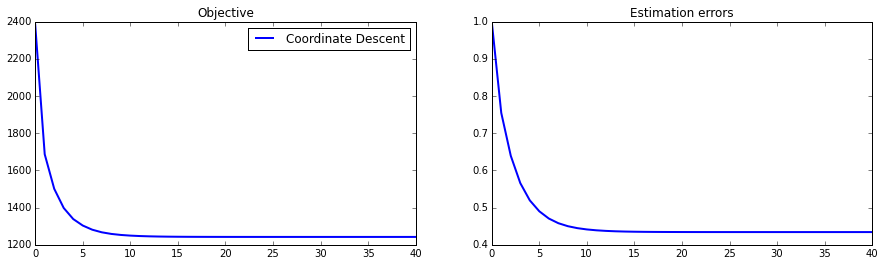

In [30]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plt.plot(obj_cd, label="Coordinate Descent", lw=2)
plt.title("Objective")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(err_cd, label="Coordinate Descent", lw=2)
plt.title("Estimation errors")

# Part 2 : Newton method

We are now investigating the logistic regression model in the context of binary classification.

We'll use the famous IRIS dataset provided by Scikit-Learn.

We'll denote by $n$ (or `n_samples`) the number of samples and $p$ (or `n_features`) the number of features, i.e. the dimension of the samples.

For the data below we'll have $p=2$.

## Part 2.0 : The data

(100,)
(100, 2)


/home/zapfack/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


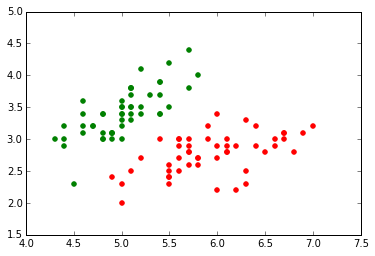

In [31]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Take only 2 features to make visualization easy
X = X[:, :2]

# Make it binary
X = X[y < 2]
y = y[y < 2]

y[y == 0] = -1

print(y.shape)
print(X.shape)

plt.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
plt.scatter(X[y < 0, 0], X[y < 0, 1], color='g')

# Part 2.1 : Logistic Regression

When we use the convention that $y=1$ for the positive class and $y=-1$ for the negative class
the L2 penalized logistic regression model reads:

$$
\hat{w}, \hat{b} = \mathop{\textrm{argmin}}_{w, b} \sum_{i=1}^n \log(1 + \exp(- y_i (x_i^\top w + b)))) + \lambda \|w\|^2
$$

where $w$ is a vector of coefficients of size $p$, $b$ is a scalar intercept and $\lambda > 0$ is a regularization parameter.

Then the prediction for a new sample is given by :

$$
y_{pred} = \textrm{sign}(x^\top w + b)
$$

### In a first step we ignore the intercept and consider the function:

$$f(w) = \sum_{i=1}^n \log(1 + \exp(- y_i (x_i^\top w)))) + \lambda \|w\|^2$$

## Questions

   - Write the formulas for the gradient and the Hessian matrix of $f$ at point $w$
   - Implement both and use the `scipy.optimize.check_grad` function from scipy to check your implementation of the gradient.
   - Implement a Newton solver for minimizing $f$.
   $$ X_{k+1} = X_{k} -\triangledown^2 f(X)^-1 * \triangledown f(x)  $$
   
   $$
      \triangledown f(w) = 2 \lambda w + \sum_{i=1}^n \frac{-y_i}{x}
   $$

In [270]:
### TODO

def pobj_logistic(X, y, w, alpha):
    # TODO
    if len(w.shape)>1:
        raise NameError('Erreur')
    n_samples, n_features = X.shape
    pobj=0
    for i in range(n_samples):
        pobj = pobj+np.log(1+np.exp(-y[i]*np.dot(X[i,],w)))
        if not (isinstance(pobj,float)):
            raise NameError('Erreur2')
        
    pobj = pobj + alpha*np.linalg.norm(w)**2
    return pobj


def grad_logistic(X, y, w, alpha):
    # TODO
    n_samples, n_features = X.shape
    grad=0
    for i in range(n_samples):
        grad = grad+ ((-y[i]*X[i,np.newaxis])/(1+np.exp(y[i]*np.dot(X[i,:],w))))
    grad = grad + alpha*2*w
    return grad

 # This should be a very small number

def hess_logistic(X, y, w, alpha):
    # TODO
    n_samples, n_features = X.shape
    hess=0
    for i in range(n_samples):
        hess = hess+ ((y[i]**2*X[i,np.newaxis].T.dot(X[i,np.newaxis])*np.exp(y[i]*np.dot(X[i,:],w))))/((1+np.exp(y[i]*np.dot(X[i,:],w)))**2)
    hess = hess + alpha*2*np.identity(n_features)
    return hess


from scipy.optimize import check_grad

wr = np.random.randn(2)
alpha = 1.
print check_grad((lambda w:pobj_logistic(X,y,w,alpha)), (lambda w:grad_logistic(X,y,w,alpha)), wr)


[  1.43e-05   5.94e-06]


In [271]:

def newton_logistic(X, y, alpha=1., w0=None):
    X = np.asarray(X, dtype=np.float)
    y = np.asarray(y, dtype=np.float)

    if w0 is None:
        #w0 = np.zeros(X.shape[1])[:,np.newaxis]
        w0 = np.zeros(X.shape[1])

    n_samples, n_features = X.shape
    
    w = w0.copy()
    
    pobj = []
    
    print("")    
    print("Lauching Newton solver...")
    print(' | '.join([name.center(8) for name in ["it", "obj"]]))

    for k in xrange(20):
    
        grad = grad_logistic(X, y, w, alpha)
        hess = hess_logistic(X, y, w, alpha)
        
        #w = w - np.linalg.inv(hess)*grad
        w=w-np.dot(np.linalg.inv(hess),grad.T)[:,0].T

        # TODO : write the w update using grad and hess

        this_pobj = pobj_logistic(X, y, w, alpha)
        pobj.append(this_pobj)
        
        print (' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % this_pobj).rjust(8)]))

    print("Global minimum : %s" % pobj[-1])

    return w, pobj

In [272]:
alpha = 0.1
w, pobj = newton_logistic(X, y, alpha=alpha)


Lauching Newton solver...
   it    |   obj   
       0 | 2.35e+01
       1 | 1.53e+01
       2 | 1.36e+01
       3 | 1.34e+01
       4 | 1.34e+01
       5 | 1.34e+01
       6 | 1.34e+01
       7 | 1.34e+01
       8 | 1.34e+01
       9 | 1.34e+01
      10 | 1.34e+01
      11 | 1.34e+01
      12 | 1.34e+01
      13 | 1.34e+01
      14 | 1.34e+01
      15 | 1.34e+01
      16 | 1.34e+01
      17 | 1.34e+01
      18 | 1.34e+01
      19 | 1.34e+01
Global minimum : 13.4471504408


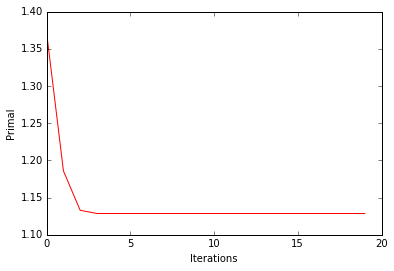

In [273]:
plt.plot(np.log10(pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

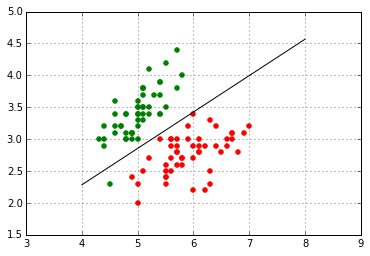

In [274]:
def plot_coefs(w, b=0.0):
    plt.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
    plt.scatter(X[y < 0, 0], X[y < 0, 1], color='g')
    xx = np.linspace(4, 8, 10)
    plt.plot(xx,  - xx * w[0] / w[1] - b / w[1], 'k')
    plt.grid('on')

plot_coefs(w)

To take into acccount the intercept we propose to add a column of 1 to the matrix X.

In [275]:
X1 = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

## Questions

    - Modify the solver so it does not penalize the intercept now present via the last column of X1

In [316]:
### TODO

def pobj_logistic_intercept(X, y, w, alpha):
    # TODO
    n_samples, n_features = X.shape
    pobj=0
    for i in range(n_samples):
        pobj = pobj+np.log(1+np.exp(-y[i]*np.dot(X[i,],w)))
        
    pobj = pobj + alpha*np.linalg.norm(w[:-1])**2
    return pobj


def grad_logistic_intercept(X, y, w, alpha):
    # TODOqrewq
    n_samples, n_features = X.shape
    grad=0
    for i in range(n_samples):
        grad = grad+ ((-y[i]*X[i,np.newaxis])/(1+np.exp(y[i]*np.dot(X[i,:],w))))
    grad[0,:-1] = grad[0,:-1] + alpha*2*w[:-1]
    return grad

 # This should be a very small number

def hess_logistic_intercept(X, y, w, alpha):
    # TODO
    n_samples, n_features = X.shape
    hess=np.zeros(n_features)
    for i in range(n_samples):
        hess = hess+ ((y[i]**2*X[i,np.newaxis].T.dot(X[i,np.newaxis])*np.exp(y[i]*np.dot(X[i,:],w))))/((1+np.exp(y[i]*np.dot(X[i,:],w)))**2)
    hess[:-1,:-1] = hess[:-1,:-1] + alpha*2*np.identity(n_features-1)
    return hess


In [317]:
# TODO

def newton_logistic_intercept(X1, y, alpha=1., w0=None):
    X = X1

    X = np.asarray(X, dtype=np.float)
    y = np.asarray(y, dtype=np.float)

    if w0 is None:
        w0 = np.zeros(X.shape[1])

    n_samples, n_features = X.shape
    
    w = w0
    
    pobj = []
    
    print("")    
    print("Lauching Newton solver...")
    print(' | '.join([name.center(8) for name in ["it", "obj"]]))

    for k in xrange(20):
        # TODO
        grad = grad_logistic_intercept(X, y, w, alpha)
        hess = hess_logistic_intercept(X, y, w, alpha)
        
        #w = w - np.linalg.inv(hess)*grad
        w=w-np.dot(np.linalg.inv(hess),grad.T)[:,0].T

        # TODO : write the w update using grad and hess

        this_pobj = pobj_logistic_intercept(X, y, w, alpha)
        pobj.append(this_pobj)

        print (' | '.join( [ ("%d" % k).rjust(8), ("%.8e" % this_pobj).rjust(8)]))

    print("Global minimum : %s" % pobj[-1])

    b = w[-1]
    w = w[:-1]
    return w, b, pobj

In [318]:
alpha = 0.1
w, b, pobj = newton_logistic_intercept(X1, y, alpha=alpha)


Lauching Newton solver...
   it    |   obj   
       0 | 2.23387575e+01
       1 | 1.35646356e+01
       2 | 1.12231400e+01
       3 | 1.09447707e+01
       4 | 1.09397357e+01
       5 | 1.09397337e+01
       6 | 1.09397337e+01
       7 | 1.09397337e+01
       8 | 1.09397337e+01
       9 | 1.09397337e+01
      10 | 1.09397337e+01
      11 | 1.09397337e+01
      12 | 1.09397337e+01
      13 | 1.09397337e+01
      14 | 1.09397337e+01
      15 | 1.09397337e+01
      16 | 1.09397337e+01
      17 | 1.09397337e+01
      18 | 1.09397337e+01
      19 | 1.09397337e+01
Global minimum : 10.9397337489


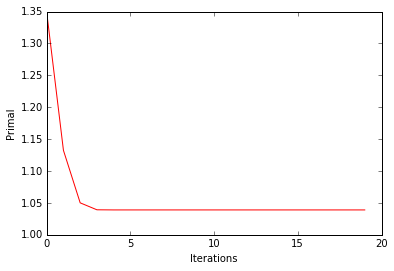

In [309]:
plt.plot(np.log10(pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

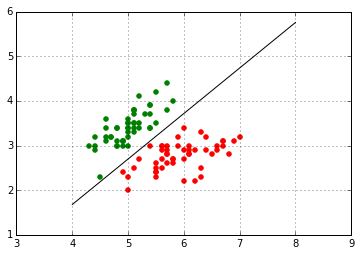

In [310]:
plot_coefs(w, b)

## Part 2.2 Newton with line search

Newton's method is only proven to converge in a neighborhood of the minimizer.

## Questions

    - Try the method newton_logistic_intercept with w0 = 0.3 * np.ones(X1.shape[1]) as a starting point.
    - What do you observe?
    
    # reponse
    les methodes de Newton ne marchent que dans un voisinage de x*. Lorsqu'on est pas dans  boule B centree en x*,on ne peut pas savoir si les $x_k$ obtenus convergeront (theorem 1 cours). en plus de cela l'on remarque que les valeurs $f(w_k)$ augmentent (très vite en plus) au point que l'on ne puisse plus les stocker en memoire au bout de quelques iterations.
    L'une des raisons de cette augmentation peut etre que la hessienne n'est pas inversible (mal conditionnee) aux points considérés.

In [319]:
alpha = 0.1
w0 = 0.3 * np.ones(X1.shape[1])
w, b, pobj = newton_logistic_intercept(X1, y, alpha=alpha,w0=w0)


Lauching Newton solver...
   it    |   obj   
       0 | 6.59471607e+01
       1 | 5.17182468e+02
       2 | 7.17412598e+03
       3 |      inf
       4 |      nan
       5 |      nan
       6 |      nan
       7 |      nan
       8 |      nan
       9 |      nan
      10 |      nan
      11 |      nan
      12 |      nan
      13 |      nan
      14 |      nan
      15 |      nan
      16 |      nan
      17 |      nan
      18 |      nan
      19 |      nan
Global minimum : nan


/home/zapfack/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp
/home/zapfack/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: overflow encountered in exp
/home/zapfack/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/zapfack/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide


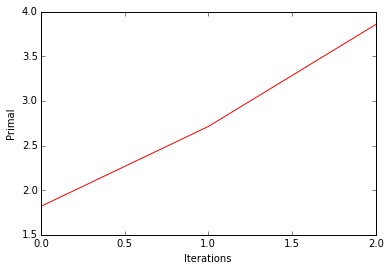

In [312]:
plt.plot(np.log10(pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

### Armijo's Line search

To overcome the instability of Newton's method when we are not in the neighbourhood of the optimum, we implement a line search that guarantees that the function value will decrease at each iteration and this leads to convergence whatever the initial point.

We recall Armijo's rule. We fix $s > 0$, $\sigma \in (0,1)$ and $\beta \in (0,1)$. For a given $w_t$ and a descent direction $d_t$, we look for $m_t$ which is the first integer $m$ such that
$$
f(w_t + s \beta^m d_t) - f(w_t) \leq  \sigma s \beta^m \nabla f(w_t)^\top d_t
$$
The new iterate is then $w_{t+1} = w_t + s \beta^{m_t} d_t$.

We shall take $d_t$ equal to Newton's update, $s=1$, $\beta = 0.5$ and $\sigma = 10^{-4}$.

## Questions

  - Modify newton_logistic_intercept to implement Armijo's line search.
  - Does the algorithm converge for w0 = 0.3 * np.ones(X1.shape[1])
  
  yes it converges (to the same point)

In [376]:
# TODO

def newton_logistic_intercept_with_linesearch(X, y, alpha=1., w0=None):
    X = np.asarray(X, dtype=np.float)
    y = np.asarray(y, dtype=np.float)

    if w0 is None:
        w0 = np.zeros(X.shape[1])
    
    n_samples, n_features = X.shape
    
    w = w0
    
    pobj = []
    
    print("")    
    print("Lauching Newton solver with line search...")
    print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    
    for k in range(20):
        # Compute descent direction with newton rule
        # descent_direction = TODO
        grad = grad_logistic_intercept(X, y, w, alpha)
        hess = hess_logistic_intercept(X, y, w, alpha)
        dt = -1*np.dot(np.linalg.inv(hess),grad.T)[:,0].T
        

        # line search
        test = False
        previous_pobj = pobj_logistic_intercept(X, y, w, alpha)
        
        
        stepsize = 1. #s
        step_decrease_rate = 0.5 #beta
        sigma = 1e-4 
        m=1
        while not test:
            # w_trial = TODO
            coef = stepsize*step_decrease_rate**m
            w_trial = w+coef*dt

            #this_grad = grad_logistic_intercept(X, y, w_trial, alpha)
            this_pobj = pobj_logistic_intercept(X, y, w_trial, alpha)
            
            # test = TODO
            scal = np.dot(dt,grad.T)
            if this_pobj-previous_pobj <= -sigma*coef*scal**2:
                break
            else:
                m=m+1
                
            stepsize *= step_decrease_rate
            
            if stepsize < 1e-10:
                print("line search failed")
                break
            
        w[:] = w_trial
        
        # neuw pobj
        this_pobj = pobj_logistic_intercept(X, y, w, alpha)
        pobj.append(this_pobj)
        
        print (' | '.join( [ ("%d" % k).rjust(8), ("%.8e" % this_pobj).rjust(8)]))

    print("Global minimum : %s" % pobj[-1])

    b = w[-1]
    w = w[:-1]
    return w, b, pobj

In [377]:
alpha = 0.1
w, b, pobj = newton_logistic_intercept_with_linesearch(X1, y, alpha=alpha, w0=0.3 * np.ones(X1.shape[1]))


Lauching Newton solver with line search...
   it    |   obj   
       0 | 1.87516611e+01
       1 | 1.33167188e+01
       2 | 1.18844122e+01
       3 | 1.12793261e+01
       4 | 1.10485619e+01
       5 | 1.09714231e+01
       6 | 1.09483703e+01
       7 | 1.09419951e+01
       8 | 1.09403128e+01
       9 | 1.09398803e+01
      10 | 1.09397706e+01
      11 | 1.09397430e+01
      12 | 1.09397361e+01
      13 | 1.09397343e+01
      14 | 1.09397339e+01
      15 | 1.09397338e+01
      16 | 1.09397338e+01
      17 | 1.09397338e+01
      18 | 1.09397337e+01
      19 | 1.09397337e+01
Global minimum : 10.939733749


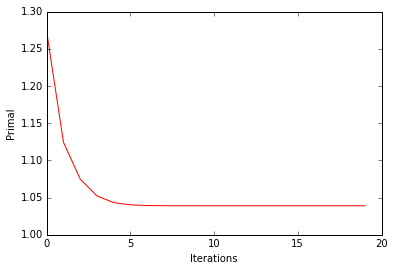

In [378]:
plt.plot(np.log10(pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

# Part 3 : L-BFGS

So far you have implemented your own solvers. In this last part you'll simply learn out to use
an existing solver. You'll be using `scipy.optimize.fmin_l_bfgs_b`.


## Question

   - Minimize the Logistic regression problem, taking into account the intercept using the `scipy.optimize.fmin_l_bfgs_b` function.

In [367]:
# TODO

all_pobj = []

def f(w):
    # pobj = TODO
    pobj = pobj_logistic_intercept(X1, y, w, alpha)
    all_pobj.append(pobj)
    return pobj

def fprime(w):
    # grad = TODO
    grad = grad_logistic_intercept(X1, y, w, alpha)
    return grad.T

from scipy.optimize import fmin_l_bfgs_b
#w0=0.3 * np.ones(X1.shape[1])
w0 = np.zeros(X1.shape[1])
x,f,_ = fmin_l_bfgs_b(f, w0, fprime=fprime)
# TODO

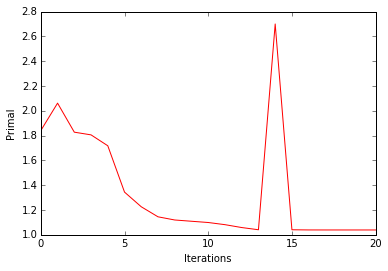

In [368]:
plt.plot(np.log10(all_pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

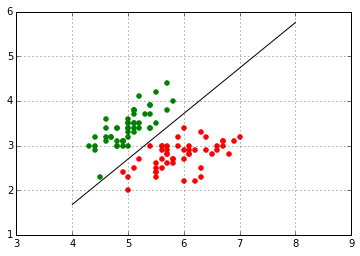

In [369]:
plot_coefs(w, b)

## Bonus Question

in case you're done early ...

   - Evaluate the performance of your implementation against sklearn.linear_model.LogisticRegression on the digits dataset.

<matplotlib.colorbar.Colorbar instance at 0x7f2104b51680>

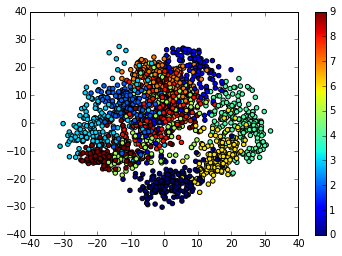

In [471]:
## import data
digits = datasets.load_digits()
X2 = digits.data
Y2 = digits.target

## Let's plot the data on the 2 first principal components
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(n_components=2)
proj = pca.fit_transform(X2)
plt.scatter(proj[:, 0], proj[:, 1], c=Y2)
plt.colorbar()

#so 0 and 1 seems to be sebarable (3 and 4 too)

(360, 64)
(360,)


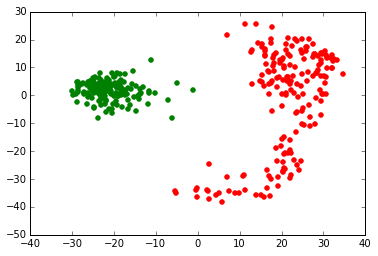

In [472]:
#Binary classification problem
X2 = X2[Y2 < 2]
Y2 = Y2[Y2 < 2]

Y2[Y2 == 0] = -1

print(X2.shape)
print(Y2.shape)

proj = pca.fit_transform(X2)
plt.scatter(proj[Y2 > 0, 0], proj[Y2 > 0, 1], color='r')
plt.scatter(proj[Y2 < 0, 0], proj[Y2 < 0, 1], color='g')
#plt.scatter(proj[:, 0], proj[:, 1], c=Y2)
#plt.colorbar()

In [397]:
# let's create a training and a test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, Y2)


In [418]:
# scikit learn implementation
alpha = 1
from sklearn import linear_model
logreg = linear_model.LogisticRegression(penalty='l2', C=alpha)
import time as t
tic = t.clock()
logreg.fit(X_train, y_train)
toc = t.clock()-tic
y_pred = logreg.predict(X_test)

print 'Time elapsed %.5f ' % toc
#logreg.score(X_test,y_test)

Time elapsed 0.00618 


In [403]:
from sklearn import metrics
print(metrics.confusion_matrix(y_pred, y_test)) 

# on confirme donc 100% de bonne classification

[[46  0]
 [ 0 44]]


In [419]:
# Own implementation (we choose a random w0)
#w0=0.3 * np.ones(X1.shape[1])
X_train2 = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
tic = t.clock()
w, b, pobj = newton_logistic_intercept_with_linesearch(X_train2, y_train, alpha=alpha)
toc = t.clock()-tic
print 'Time elapsed %.5f ' % toc


Lauching Newton solver with line search...
   it    |   obj   
       0 | 8.69076001e+01
       1 | 4.84807395e+01
       2 | 2.85000306e+01
       3 | 1.71859460e+01
       4 | 1.05353932e+01
       5 | 6.54981158e+00
       6 | 4.13269307e+00
       7 | 2.65402221e+00
       8 | 1.74421722e+00
       9 | 1.18386321e+00
      10 | 8.40638418e-01
      11 | 6.32993660e-01
      12 | 5.09847139e-01
      13 | 4.39114509e-01
      14 | 4.00585252e-01
      15 | 3.81289919e-01
      16 | 3.72721327e-01
      17 | 3.69431718e-01
      18 | 3.68336718e-01
      19 | 3.68011323e-01
Global minimum : 0.36801132308
Time elapsed 10.66334 


In [412]:
#Predicted class
y_pred = np.sign(np.dot(X_test,w.T)+b)
print(metrics.confusion_matrix(y_pred, y_test)) 

[[46  0]
 [ 0 44]]


## Comments
- these data are not very well to compare the performance in term of classification error
- however, we notice that the scikit-learn implementation is a lot faster probably because of it is optimized compare to our code

In [454]:
# Let's classify others digit (separer 7 des autres)


acc_sci = []
acc_own = []
for d in range(np.max(10)):
    digits = datasets.load_digits()
    X2 = digits.data
    Y2 = digits.target
    Y2[Y2!=d]=-1
    Y2[Y2==d]=1

    X_train, X_test, y_train, y_test = train_test_split(X2, Y2)
    #print X_test.shape
    #print y_test.shape
    # scikit
    logreg = linear_model.LogisticRegression(penalty='l2', C=alpha)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    #print(metrics.confusion_matrix(y_pred, y_test)) 
    acc_sci.append(metrics.accuracy_score(y_pred, y_test))
    X_train2 = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
    w, b, pobj = newton_logistic_intercept_with_linesearch(X_train2, y_train, alpha=alpha)
    y_pred = np.sign(np.dot(X_test,w.T)+b)
    acc_own.append(metrics.accuracy_score(y_pred, y_test))



Lauching Newton solver with line search...
   it    |   obj   
       0 | 4.62279327e+02
       1 | 2.75394862e+02
       2 | 1.73195836e+02
       3 | 1.11924811e+02
       4 | 7.35391242e+01
       5 | 4.88456926e+01
       6 | 3.26570793e+01
       7 | 2.18941171e+01
       8 | 1.46918917e+01
       9 | 9.90570843e+00
      10 | 6.78089667e+00
      11 | 4.77176880e+00
      12 | 3.48821703e+00
      13 | 2.66609470e+00
      14 | 2.14190059e+00
      15 | 1.82186024e+00
      16 | 1.64076059e+00
      17 | 1.54593671e+00
      18 | 1.50072337e+00
      19 | 1.48185433e+00
Global minimum : 1.48185433258

Lauching Newton solver with line search...
   it    |   obj   
       0 | 5.01993538e+02
       1 | 3.27813234e+02
       2 | 2.29280524e+02
       3 | 1.67386098e+02
       4 | 1.26178880e+02
       5 | 9.75161046e+01
       6 | 7.68061057e+01
       7 | 6.13752542e+01
       8 | 4.97020851e+01
       9 | 4.09201936e+01
      10 | 3.43829838e+01
      11 | 2.95840031e+01
      12 

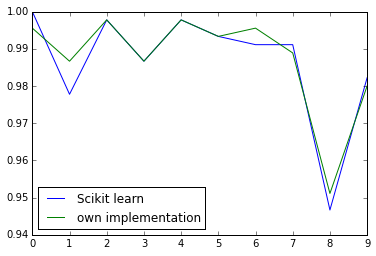

In [458]:
# plot
plt.figure()
plt.plot(acc_sci, label='Scikit learn')
plt.plot(acc_own, label='own implementation')
plt.legend(loc='best')

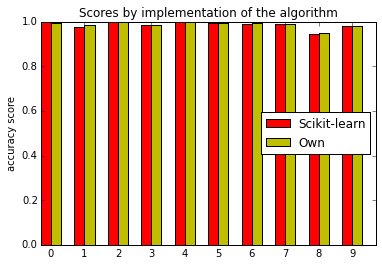

In [478]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(10),acc_sci,width=0.3, color='r')
rects2 = ax.bar(np.arange(10)+0.3, acc_own, width=0.3, color='y')

ax.set_ylabel('accuracy score')
ax.set_title('Scores by implementation of the algorithm')
ax.set_xticks(np.arange(10)+0.3)

ax.set_xticklabels(('0','1', '2', '3', '4', '5', '6', '7', '8','9'))
ax.legend((rects1[0], rects2[0]), ('Scikit-learn', 'Own'),loc='center right')

In [467]:
print np.mean(acc_sci)
print np.mean(acc_own)

0.986444444444
0.987333333333


## Comments
    - We notice that the 2 implementations have pretty much the same performance in terms of classification errors. Our own implementation is sligthly better